# Tabular Data Science - Part #2
### Group Members: 
* Tal Ariel Ziv
* Arnon Lutsky

#### Introduction:
In this project, we aim to explore the fascinating intersection of movies and data science by building a predictive model for box office revenue.<br>
In this part of the project we will improve the pipeline and our model's performance from the previews work, by modifying our data and applying more sophisticated insights on our data.<br>
This includes adding features, normalizing features and using different algorithms learned in class.<br>

### 0. Imports
Let's start with importing the wanted libraries that we will work with in this part.

In [2]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import ast

import warnings
warnings.filterwarnings("ignore")

import pickle

import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

import shap

### 1. Error Analysis Conclusions:

Before we begin examining our previews work, let's import libreries and load the wanted information. We will load the data from the `pickle` files.


In [3]:
with open('dataset.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)

with open('X_test.pkl', 'rb') as f:
    loaded_X_test = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    loaded_y_test = pickle.load(f)

with open('fitted_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

In part 1 of the project, we saw that the residuals percentage were the highest when `revenue` was smaller, as seen in Figure 7 in the last parts notebook.<br>
This may be for several reasons:<br>
* Data's Distribution: as seen in figure 1 of last part's notebooks (and below), there is a high skewness in the distribution of the `revenue` feature. Because many movies had low revenue the model could get "confused" and predict low `revenue` for many movies with higher `revenue` values.<br>

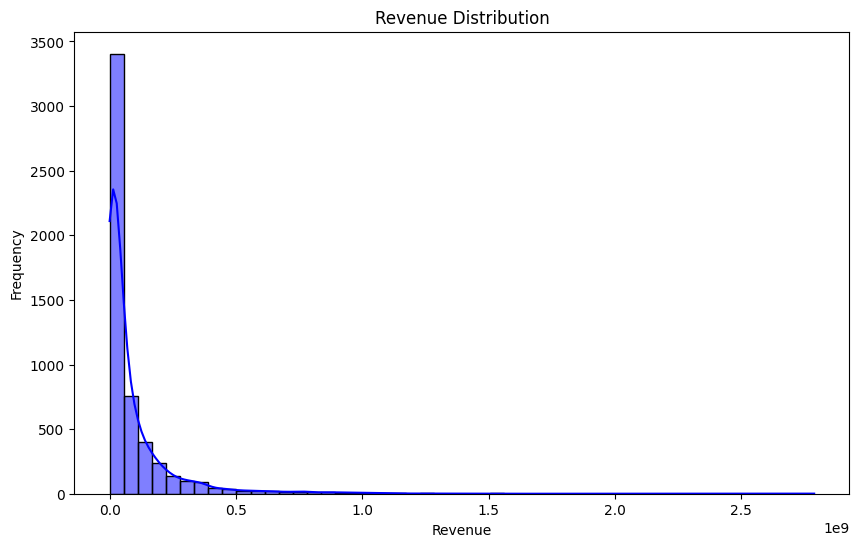

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(loaded_dataset['revenue'], bins=50, kde=True, color='blue') 
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

* Massive filtering left us with around 10% of the dataset. We will implement ways to use data that may have a missing value. Let's see how many lines the original dataset included, and how many the filtered data set has.<br>

In [5]:
data_movies = pd.read_csv("Data/movies_metadata.csv",index_col='id')

num_lines_original = len(data_movies)
print(f"Number of lines in the original dataset: {num_lines_original}")

num_lines_filter = len(loaded_dataset)

print(f"Number of lines in the filtered dataset: {num_lines_filter}")

Number of lines in the original dataset: 45466
Number of lines in the filtered dataset: 5368


As you can see, we lost a very big amount of the data and were left with only 11% of the data. One of our adjustment will be trying to find different movies box office and revenue to enlarge our dataset.

* In the last part we saw the importance of different features. Some of the most important ones were `budget`, `vote_count`, and `year_of_release`. However, attributes like `crew_size` and `cast_size` did not have as much importance as we might thought they have. <br><br>
We think that the reason for this is because we only looked at the size of cast/crew, without giving attention to the actual actors, directors, and producers. The same thing with `production_companies`.<br><br>
**Let's look at the shap plotting from the last part of the project:**

In [6]:
shap_sample = loaded_X_test.sample(500)
explainer = shap.Explainer(loaded_pipeline.predict, shap_sample)
shap_values = explainer(shap_sample)

PermutationExplainer explainer: 501it [00:43,  9.70it/s]                         


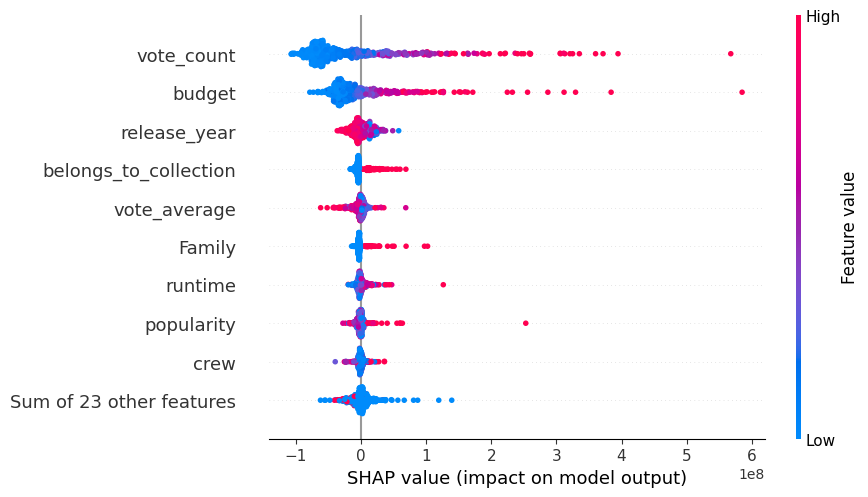

In [7]:
shap.plots.beeswarm(shap_values)

While several features, such as `vote_count`, `budget`, and `release_year`, shows strong importance in determining the `revenue`, the feature crew has relatively low importance, suggesting it did not significantly impact the model's predictions. This indicates that the information contained in the crew feature might not have been effectively utilized.<br><br>
Additionally, we currently only use the `release_year` to capture temporal information about movies. However, including more granular time-related features, such as the release month and release day, could provide additional meaningful context.<br><br>
**Now, let's look for example at the crew's importance in our model.**

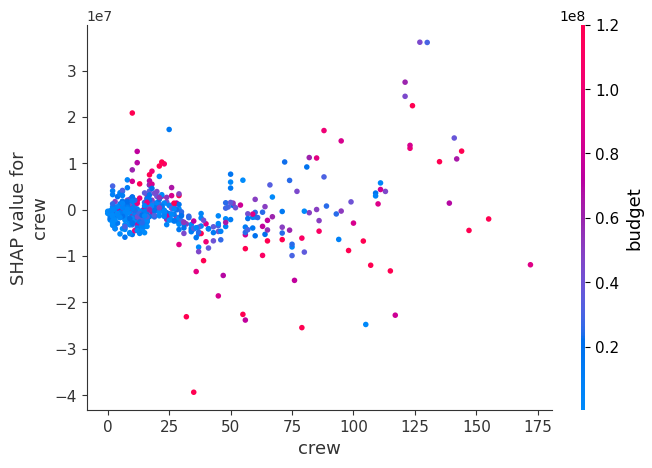

In [8]:
shap.dependence_plot('crew', shap_values.values, shap_sample)

As you can see, the SHAP value of the crew is very low. This relatively small range of SHAP values clustered close to zero indicates that crew size had a minimal impact on the model's predictions. Why is that?<br>
1. The raw crew size alone may not sufficiently capture the complexity of how the composition of the crew influences a movie's revenue. For example, specific roles like director, cinematographer etc. might have more predictive power than the total number of crew members.
2. The impact of crew size could depend heavily on other contextual factors, such as the type of movie, for example small indie films vs. blockbuster productions, or maybe the production region. Without explicitly modeling these interactions, the crew feature may appear less significant.


**We will try to fix that in this part of the project.**

* in the last part we added 19 columns of `genre`, that might help predict the movies `revenue`. However, we think that some genres may have little impact on the model's prediction.<br>

Now, we would like to see how the different genres contribute to the predicted `revenue`, and see if there is a change that we would like to make.

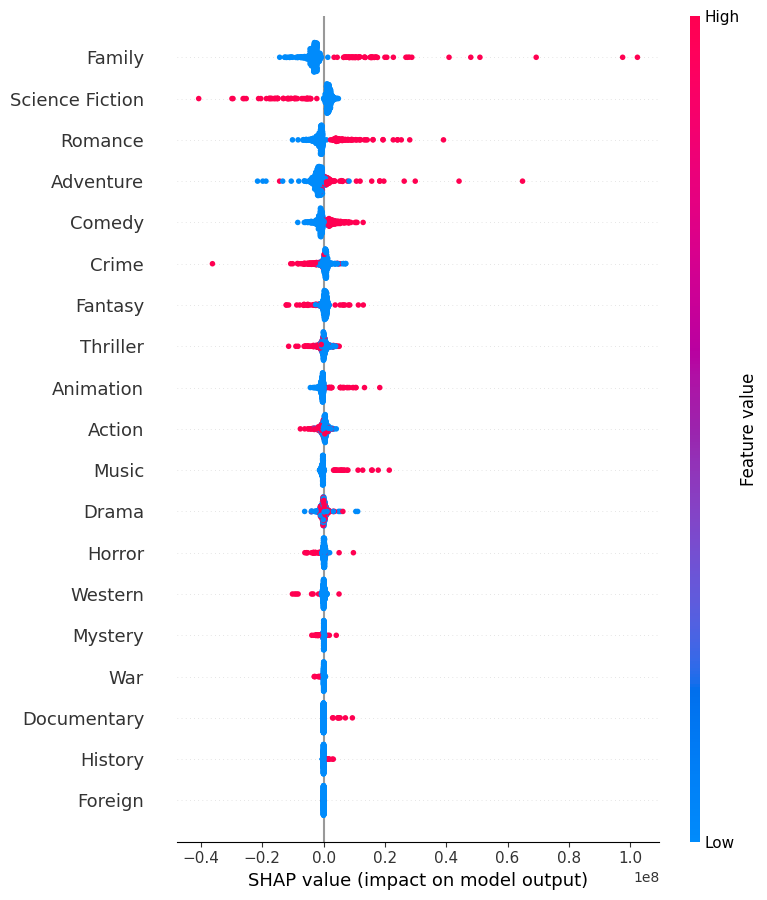

In [9]:
genre_columns = [
    'Foreign', 'Science Fiction', 'Romance', 'Action', 'Crime', 'Thriller', 
    'Family', 'Fantasy', 'Western', 'War', 'Horror', 'History', 'Animation', 
    'Comedy', 'Adventure', 'Mystery', 'Documentary', 'Music', 'Drama'
]

genre_indices = [shap_sample.columns.get_loc(col) for col in genre_columns if col in shap_sample.columns]

genre_shap_values = shap_values[:, genre_indices]

shap.summary_plot(genre_shap_values.values, shap_sample[genre_columns], feature_names=genre_columns)


This SHAP plot above demonstrates the contribution of various genres to the prediction of the `revenue`. The x-axis represents the SHAP value, which indicates the impact of each genre on the model's predictions. A positive SHAP value suggests that the genre increases the predicted revenue, while a negative SHAP value indicates a decrease.

**What can we learn from this SHAP plot?**

1. **High Impact Genres**: Genres such as **Family**, **Adventure**, **Romance**, and **Comedy** show relatively significant contributions to the model's predictions. These genres are likely influencing the revenue more substantially.
   
2. **Low Impact Genres**: Certain genres, like **War**, **Foreign**, **Western**, and **History**, have much smaller SHAP values and limited contribution to the model's predictions. Their influence on revenue prediction appears negligible compared to other genres.

3. **Potential Redundancy**: Many genres have minimal or overlapping contributions, which may not add meaningful distinctions in the model's output.

Given that some genres have little to no impact on predictions, we could consider dropping those genres or grouping them into an "Other" category. This simplification might:
- Reduce feature dimensionality, making the model simpler and potentially more generalizable.
- Improve interpretability by focusing on the genres that matter most to revenue prediction.


Now, we would like to exam the connection between month and day with the `revenue`. We would like to see if its worth to add those features to our dataset.<br>

In order to do that, we will look at the mean `revenue` by month and by day, and try to understand if we see any connection. We will take the data from the original dataset, and calculate the mean `revenue` by month and days

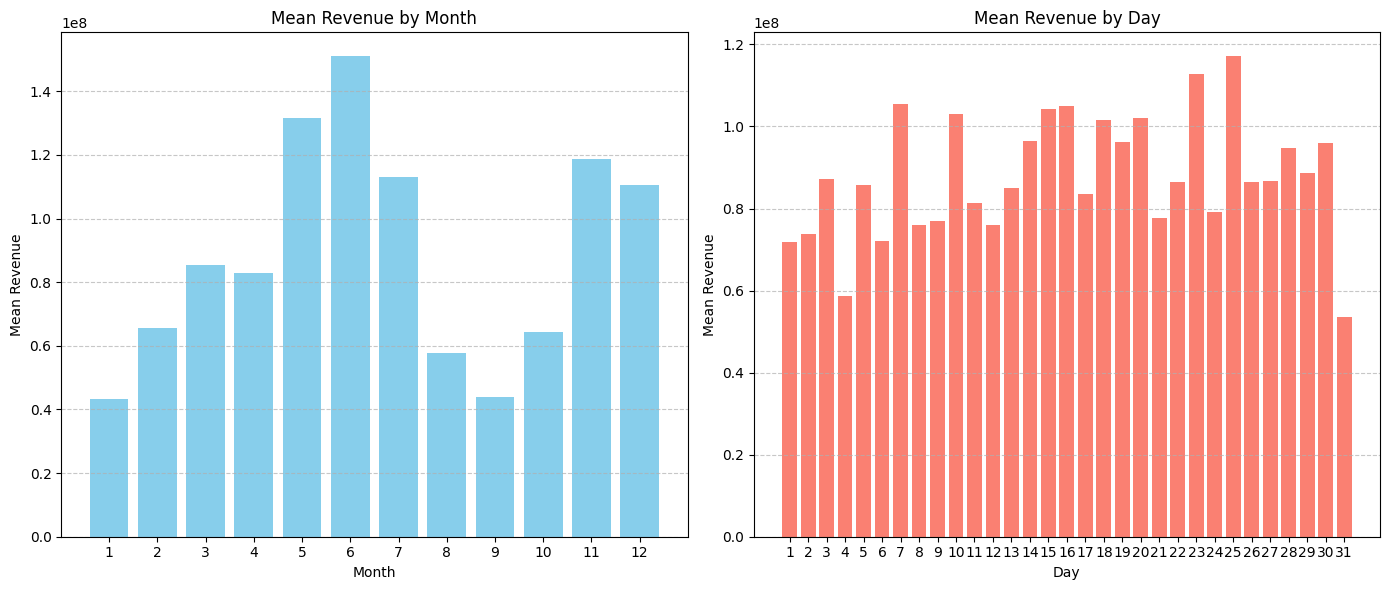

In [10]:
original_data = pd.read_csv("Data/movies_metadata.csv",index_col='id')

original_data['release_date'] = pd.to_datetime(original_data['release_date'], errors='coerce')

original_data['release_month'] = original_data['release_date'].dt.month
original_data['release_day'] = original_data['release_date'].dt.day

original_data.index = pd.to_numeric(original_data.index, errors='coerce')

dataset = pd.merge(
    loaded_dataset,
    original_data[['release_month', 'release_day']],
    left_index=True,
    right_index=True,
    how='inner'
)

mean_revenue_by_month = dataset.groupby('release_month')['revenue'].mean()

mean_revenue_by_day = dataset.groupby('release_day')['revenue'].mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(mean_revenue_by_month.index, mean_revenue_by_month.values, color='skyblue')
ax[0].set_title('Mean Revenue by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Mean Revenue')
ax[0].set_xticks(range(1, 13))
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1].bar(mean_revenue_by_day.index, mean_revenue_by_day.values, color='salmon')
ax[1].set_title('Mean Revenue by Day')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Mean Revenue')
ax[1].set_xticks(range(1, 32))
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**What can we understand from the plots?**<br>
1. *Mean Revenue by Month:* From the bar chart on the left, we can observe that the highest mean revenue is associated with movies released in May and June, with a significant peak in these months. This suggests that movies released during this period, which often coincides with the summer blockbuster season, tend to generate higher revenue.<br>On the other hand, the months of January, August, and September show relatively lower mean revenue. These months may align with periods of fewer high-budget or highly anticipated movie releases.<br><br>
2. *Mean Revenue by Day:* From the bar chart on the right, we can observe a generally consistent mean revenue across the days of the month. However, there is a noticeable peak around Day 24, suggesting that movies released on or near this day may perform better on average. Conversely, Day 31 seems to have lower mean revenue, which might be due to fewer movies being released on the last day of the month.<br><br>

This analysis highlights a seasonal trend in movie revenue, where the release month significantly impacts financial success, particularly for May and June. While daily trends are less pronounced, specific dates may still influence revenue patterns.

To improve our predictive model, it would be valuable to include both `release_month` and `release_day` as features. These cyclical time-based features can capture seasonal and temporal effects that significantly contribute to a movie's revenue.

### 2. Work Plan
Our mission is to improve the model's predictions and improve the statistics we got on our original model. In order to do that, we will implement the following:<br>
1. Applying some transformation on the `revenue` field.
2. Finding information about budget and revenue for movies in order to enlarge our dataset.
3. Use smart feature engineering to re-model some of our current features, and add some new ones.
4. Using columns we ignored in the last part of the project.

We hope that by applying this changes we will get a much more expressive model that will be able to capture the trends of different movies.<br><br>
<font size=4px>**Let's Begin!**</font>

### 3. Feature engineering


Before changing the features, we will make a copy of our loaded dataset. this copy will hold all of the changed features and attributes. We wanted to keep track on our original data, so the comparison will be easier later.

In [11]:
dataset = loaded_dataset.copy()

<font size=4px>*Adding New Data*</font>

As we have already seen in the data display and data count, we have very little data, and not much data of high budget movies.<br>
In order to fix that, we found another dataset that contains information about the movies we have, and we would like to take information from there. To begin with, we will found movies that did not have `revenue` or `budget` value.<br>
We will find them and run them through the pipeline of editing we did in the last part's notebook.<br><br>
Let's begin by loading the old dataset and the new dataset that we will take information from.

<font size=5px color='red'>IMPORTANT</font><br>
The TMDB_movie_dataset has been uploaded to the github repository, however if you try to pull/clone the repository to your own computer, it might no copy the dataset (because it is very big). Therefor, if you don't want to load the new data, you can skip to loading the new dataset. Don't run the cells in between, but you can (and should) read what we did.

In [12]:
existing_data = pd.read_csv("Data/movies_metadata.csv", index_col='id')
new_data = pd.read_csv("Data/TMDB_movie_dataset_v11.csv", index_col='id')

Now, we want to tak the lines from the new data that has information (not null and revenue/budget greater than 0). We want to find the lines in the old data that didn't have the information we wanted, and fill in that information from the new data.

In [13]:
existing_data.index = pd.to_numeric(existing_data.index, errors='coerce')
new_data.index = pd.to_numeric(new_data.index, errors='coerce')

new_data = new_data.dropna(subset=['budget', 'revenue'])

existing_data['budget'] = pd.to_numeric(existing_data['budget'], errors='coerce')
existing_data['revenue'] = pd.to_numeric(existing_data['revenue'], errors='coerce')
new_data['budget'] = pd.to_numeric(new_data['budget'], errors='coerce')
new_data['revenue'] = pd.to_numeric(new_data['revenue'], errors='coerce')

missing_data = existing_data[(existing_data['budget'] <= 0) | (existing_data['revenue'] <= 0)]

valid_new_data = new_data[(new_data['budget'] > 0) & (new_data['revenue'] > 0)]

After that, we will remove duplicates from our data, and begin the merge process.

In [14]:
missing_data = missing_data[~missing_data.index.duplicated(keep='first')]
valid_new_data = valid_new_data[~valid_new_data.index.duplicated(keep='first')]

filled_data = pd.merge(
    missing_data,
    valid_new_data[['budget', 'revenue']],
    left_index=True,
    right_index=True,
    suffixes=('_old', ''),
    how='inner'
)

After the merger process, we want to remove duplicates (if any), and organize the data in the same order as the existing data.<br>
After we finish the process, we can see that we found **2102 new lines!!!**, an amazing number that will help us train the model better.

In [15]:
filled_data = filled_data[~filled_data.index.duplicated(keep='first')]

filled_data = filled_data.drop(columns=['budget_old', 'revenue_old'], errors='ignore')

cols = ["original_title", "belongs_to_collection", "genres","original_language", "budget",
        "popularity", "production_companies", "production_countries", "release_date", "runtime",
        "spoken_languages", "vote_average", "vote_count", "revenue"]
new_movies_data = filled_data[cols]
print("Number of movies added: " + str(len(new_movies_data)))

Number of movies added: 2102


Now, let's look at some of the new movies we added.

In [16]:
new_movies_data.head()

,original_title,belongs_to_collection,genres,original_language,budget,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,vote_average,vote_count,revenue
id,,,,,,,,,,,,,,
15602.0,Grumpier Old Men,"{'id': 119050, 'name': 'Grumpy Old Men Collect...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,25000000,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",6.5,92.0,71500000
11860.0,Sabrina,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",en,58000000,6.677277,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1995-12-15,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",6.2,141.0,53672080
12110.0,Dracula: Dead and Loving It,NaN,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",en,30000000,5.430331,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1995-12-22,88.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",5.7,210.0,10772144
21032.0,Balto,"{'id': 117693, 'name': 'Balto Collection', 'po...","[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",en,31000000,12.140733,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,78.0,"[{'iso_639_1': 'en', 'name': 'English'}]",7.1,423.0,11348324
1710.0,Copycat,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",en,20000000,10.701801,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-27,124.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",6.5,199.0,32000000


#### Uploading New Dataset
Now, we want to add the new lines to our old data. However, our old data went through a lot of changes in the last notebook, where we added features and changes.<br><br>
In order to avoid code copying, we added the new data to our old notenook, and ran the pipeline of editing from it. **You won't be able to see this part here**. However, the new data (the old one and the new lines) with the changes from the last notebook, have been saved in the pkl file `new_dataset`.<br><br>All we have to do is load that dataset. Now we can work with the extra lines we added!

In [17]:
with open('new_dataset.pkl', 'rb') as f:
    new_dataset = pickle.load(f)

dataset = new_dataset

<font size=4px>*Transformation On `Revenue` Field*</font>

We will try to perform some transformation on the `revenue` to decrease the skewness.
Let's examine the option of applying square root on our `revenue` field.

Text(0, 0.5, 'Frequency')

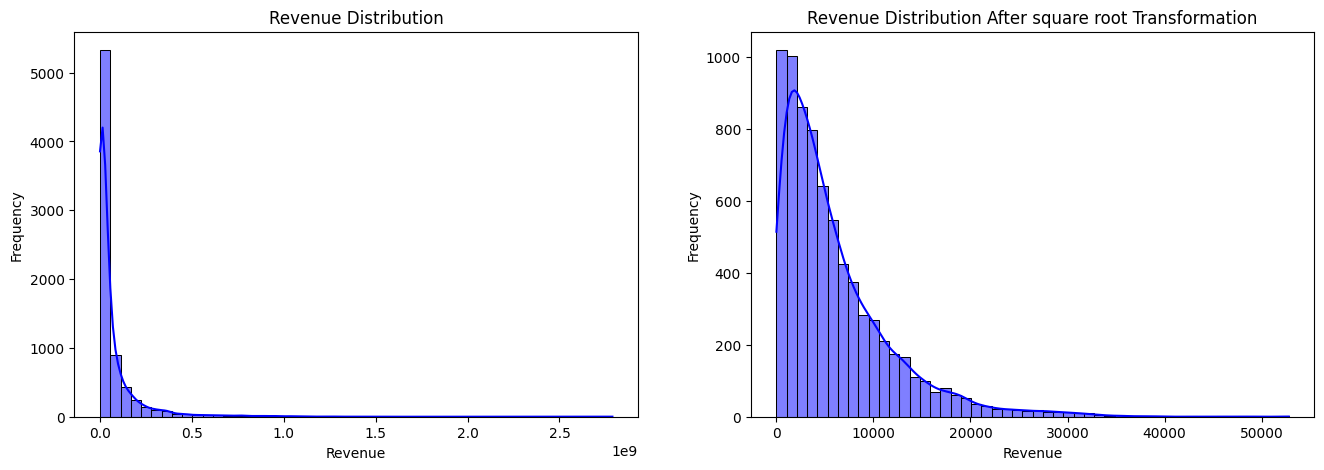

In [18]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.histplot(dataset['revenue'],bins=50, kde=True, color='blue', ax=ax[0])
ax[0].set_title("Revenue Distribution")
ax[0].set_xlabel("Revenue")  
ax[0].set_ylabel("Frequency") 

n = 2
transformed_revenue = np.power(pd.to_numeric(dataset['revenue'], errors='coerce'), 1/n)

sns.histplot(transformed_revenue,bins=50, kde=True, color='blue', ax=ax[1])
ax[1].set_title("Revenue Distribution After square root Transformation")
ax[1].set_xlabel("Revenue")  
ax[1].set_ylabel("Frequency")

The plot shows that the data distribution behaves more normally and is less skewed. Why are we going to use this change?

Reduction of Skewness:

* In the original distribution (left plot), the data is heavily right-skewed, with a concentration of lower revenue values and a long tail for higher values.
* After the square root transformation (right plot), the distribution becomes more balanced and less skewed, allowing the model to learn patterns more effectively across the entire range of values.

Handling Outliers:

* In the untransformed data, extreme values (outliers) in revenue dominate the scale, which can negatively impact model training.
* The square root transformation compresses these extreme values, reducing their influence on the model while preserving their relative ordering.

To sum up, by stabilizing the variance and reducing skewness, the transformation ensures that the model is not biased toward predicting the majority class (low revenue) while underperforming for high-revenue cases.

**Now the data is more normally distributed**, which might help the model learn the dataset better. Let's add the new revenue to the dataset. We will apply the other feature engineering and then check if those changes helped the model.<br><br>

In [19]:
dataset["transformed_revenue"] = transformed_revenue
dataset = dataset.drop(columns=['revenue'])

**Let's move on to the third change we would like to apply.**<br><br>
<font size=4px>*Attribute Editing*</font><br><br>
Now, we would like to edit some of our existing features. We will begin by editing the year attribute. We would like to take in account not only the year of release, but also the month and day, because they also have effect on the revenue.<br>
In order to do that, we need to add the `date` column back, and extract from it the `year`, `month` and the `day`. Also, we would add a new feature that will help the model learn.

In [20]:
original_data = pd.read_csv("Data/movies_metadata.csv",index_col='id')

original_data['release_date'] = pd.to_datetime(original_data['release_date'], errors='coerce')

original_data['release_month'] = original_data['release_date'].dt.month
original_data['release_day'] = original_data['release_date'].dt.day

original_data['release_month_sin'] = np.sin(2 * np.pi * original_data['release_month'] / 12)
original_data['release_month_cos'] = np.cos(2 * np.pi * original_data['release_month'] / 12)
original_data['release_day_sin'] = np.sin(2 * np.pi * original_data['release_day'] / 31)
original_data['release_day_cos'] = np.cos(2 * np.pi * original_data['release_day'] / 31)

original_data.index = pd.to_numeric(original_data.index, errors='coerce')

dataset = pd.merge(
    dataset,
    original_data[['release_month_sin', 'release_month_cos', 'release_day_sin', 'release_day_cos']],
    left_index=True,
    right_index=True,
    how='inner'
)

Time-based features like months and days are cyclical; after December comes January, and after the 31st day comes the 1st. Traditional linear representations, for example January as 1, December as 12, don't effectively capture this cyclical relationship, potentially leading to decreased model performance.

By applying sine and cosine transformations, we map these cyclical features onto a circular space, preserving their cyclical nature. This method ensures that the model perceives December (12) and January (1) as being close to each other, reflecting the true cyclical relationship.

The transformations we made convert the `release_month` and `release_day` into two-dimensional representations that reflect their cyclical properties. This encoding can improve the performance of our model by providing a more accurate representation of time-based features.<br>

resource:  [The best way to encode dates, times, and other cyclical features](https://harrisonpim.com/blog/the-best-way-to-encode-dates-times-and-other-cyclical-features?utm_source=chatgpt.com).

<font size=4px>*Dropping Features*</font><br><br>
Now, as we have seen before we have some genre's that does not impact on the model's prediction. Let's first see how many movies we have in each genre.

In [21]:
genre_columns = [
    'Foreign', 'Science Fiction', 'Romance', 'Action', 'Crime', 'Thriller', 
    'Family', 'Fantasy', 'Western', 'War', 'Horror', 'History', 'Animation', 
    'Comedy', 'Adventure', 'Mystery', 'Documentary', 'Music', 'TV Movie', 'Drama'
]

genre_counts = dataset[genre_columns].sum()
print("Counts of ones in each genre column:")
print(genre_counts)

Counts of ones in each genre column:
Foreign              77
Science Fiction     793
Romance            1481
Action             1823
Crime              1137
Thriller           1998
Family              717
Fantasy             660
Western             132
War                 263
Horror              823
History             304
Animation           364
Comedy             2676
Adventure          1185
Mystery             585
Documentary          80
Music               298
TV Movie              3
Drama              3678
dtype: int64


Now, we can see that some genres are not that common, and probably will not have an impact on the predicted `revenue`. At the beginning of the notebook we saw that the movies **War**, **Foreign**, **Western**, and **History** had small SHAP value, and now we can see that they appear in a small amount of movies.<br><br>
**Let's try to drop the genres that appear in less than 4% of movies, and check their other column with 1**

In [22]:
threshold = 0.05 * len(dataset)

columns_to_drop = genre_counts[genre_counts < threshold].index.tolist()
print(f"Columns to drop: {columns_to_drop}")

dataset['other'] = 0

for col in columns_to_drop:
    dataset['other'] = dataset['other'] | dataset[col]

dataset = dataset.drop(columns=columns_to_drop)

Columns to drop: ['Foreign', 'Western', 'War', 'History', 'Animation', 'Documentary', 'Music', 'TV Movie']


We can see that the genres that dropped were **Foreign, Western, War, Documentary, Music and TV Movie** we will see later what impact it had on the model.

<font size=4px>*Adding Features*</font><br><br>
We have seen that the `crew size` attribute did not influence as much as we expected.<br>
To try and make the feature more meaningful, we'll extract the average `revenue` from each movie a cast / crew member was in. Let's start by creating a dataset that holds the `crew`, the `cast` and the `revenue` values of all the movies we are working with.

1. We will start by loading the credits dataset that holds all the crews and casts information.

In [23]:
data_credits = pd.read_csv("Data/credits.csv",index_col='id')
cols = ["crew", "cast"]
data_credits = data_credits[cols]
data_credits.head()

,crew,cast
id,,
862,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'cast_id': 14, 'character': 'Woody (voice)',..."
8844,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'cast_id': 1, 'character': 'Alan Parrish', '..."
15602,"[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
31357,"[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'cast_id': 1, 'character': ""Savannah 'Vannah..."
11862,"[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'cast_id': 1, 'character': 'George Banks', '..."


2. Next, we'll filter and evaluate the data so we will be able to work with it.<br> **We want to take only the columns that have information about the crew and the cast.**

In [24]:
data_credits_filtered = data_credits[:]
data_credits_filtered['crew'] = data_credits['crew'].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) and isinstance(x, str) else 0
)

data_credits_filtered['cast'] = data_credits_filtered['cast'].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) and isinstance(x, str) else 0
)

3. Now we will extract the `revenue` column from our working dataset:

In [25]:
cols = ["transformed_revenue"]
dataset_rev = dataset[cols]

4. Finally, we will merge the two tables together for calculating a score for each cast member or actor, based on the avrage revenue of movies.<br>
Let's take a look at the new table.

In [26]:
dataset_rev.index = dataset_rev.index.astype(int)
data_credits_filtered.index = data_credits_filtered.index.astype(int)

avg_rev_data = pd.merge(data_credits_filtered, dataset_rev, on='id')
avg_rev_data.head()

,crew,cast,transformed_revenue
id,,,
862,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'cast_id': 14, 'character': 'Woody (voice)',...",19327.545964
8844,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'cast_id': 1, 'character': 'Alan Parrish', '...",16211.022454
15602,"[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...",8455.767263
31357,"[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'cast_id': 1, 'character': 'Savannah 'Vannah...",9025.084820
949,"[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...",13690.756663


5. We will save the new table in a pickle file for convince, and load it back afterwards. The computation takes some time, so if you don't want to run all of it, just continue from this part.

In [27]:
with open('avg_rev_data.pkl', 'wb') as f:
    pickle.dump(avg_rev_data, f)
    
with open('avg_rev_data.pkl', 'rb') as f:
    avg_rev_data = pickle.load(f)

We want to create a table that holds the average revenue of each cast / crew member.<br><br>
6. We'll begin by getting a list of the `revenues` of each movie a person was a part of.<br>
We'll do this by going through all movies and creating a dictionary that maps a crew / cast member's id to a list of revenues of movies they were in.<br>

In [28]:
cast_movie_mapping = {}
crew_movie_mapping = {}

for index, row in avg_rev_data.iterrows():
    crew_members = row["crew"]
    cast_members = row["cast"]
    movie_rev = row["transformed_revenue"]

    for cast_member in cast_members:
        id = cast_member['id']
        if id not in cast_movie_mapping:
            cast_movie_mapping[id] = [movie_rev]
        else:
            cast_movie_mapping.get(id, []).append(movie_rev)
            
    for crew_member in crew_members:
        id = crew_member['id']
        if id not in crew_movie_mapping:
            crew_movie_mapping[id] = [movie_rev]
        else:
            crew_movie_mapping[id].append(movie_rev)

7. Now, we'll calculate the average `revenue` of all the movies in each persons list.<br> If a person was in one film only they may not be as interesting to us and may confuse the model with too low / high of an average.<br>

**We will begin with the cast:**

In [29]:
for id, arr in cast_movie_mapping.items():
    if len(cast_movie_mapping[id]) <= 1:
        cast_movie_mapping[id] = 0
    else:
        cast_movie_mapping[id] = np.average(arr).astype(np.float64) 


**Moving on to calculates for the crew members:**

In [30]:
for id, arr in crew_movie_mapping.items():
    if len(crew_movie_mapping[id]) <= 1:
        crew_movie_mapping[id] = 0
    else:
        crew_movie_mapping[id] = np.average(arr).astype(np.float64) 

8. We will transform the python dictionaries, in which we saved the average revenue, to pandas DataFrame for easier use.

In [31]:
cast_movie_mapping = pd.DataFrame.from_dict(cast_movie_mapping, orient='index')
crew_movie_mapping = pd.DataFrame.from_dict(crew_movie_mapping, orient='index')

9. We'll change the name of the average revenue to a more meaningful one. In addition, We'll remove all of the persons with average revenue of 0, because they won't contribute to the prediction.

In [32]:
crew_movie_mapping["avg_rev"] = crew_movie_mapping[0]
crew_movie_mapping = crew_movie_mapping.drop(columns=[0])
cast_movie_mapping["avg_rev"] = cast_movie_mapping[0]
cast_movie_mapping = cast_movie_mapping.drop(columns=[0])

cast_movie_mapping = cast_movie_mapping[(cast_movie_mapping['avg_rev'] > 0)].dropna(subset=['avg_rev'])
crew_movie_mapping = crew_movie_mapping[(crew_movie_mapping['avg_rev'] > 0)].dropna(subset=['avg_rev'])

After finding the data, we would like to see the distribution of the average revenue for different actors/crew members.<br>
The next figure shows a scatter plot of the average revenue (y axis) for all actors (x axis - IMDB id of an actor)

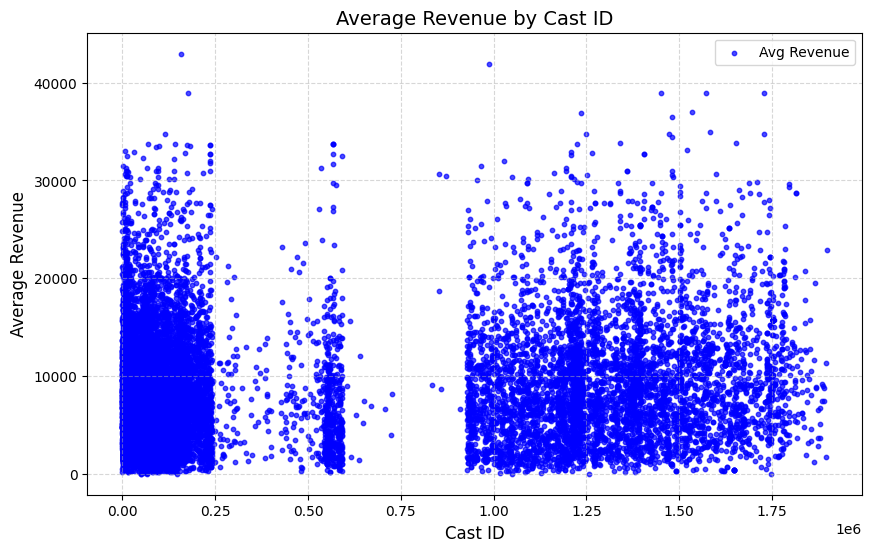

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(cast_movie_mapping.index, cast_movie_mapping['avg_rev'], alpha=0.7, s=10, c='blue', label='Avg Revenue')

plt.xlabel('Cast ID', fontsize=12)
plt.ylabel('Average Revenue', fontsize=12)
plt.title('Average Revenue by Cast ID', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()

In this plot, we observe the distribution of average movie revenues associated with different cast members, depicted across different Cast IDs. The concentration of points at the lower end of the revenue spectrum, particularly in dense clusters, suggests that a significant proportion of actors are involved in films that do not achieve high box office revenues. This could be attributed to some factors, including the roles they play, the type of movies they are involved in, or their market reach and popularity.

We can see that there are clear outliers where certain cast members are associated with significantly higher revenues. These outliers likely represent well-known actors who not only draw larger audiences but also tend to be involved in higher-budget productions which typically command greater box office returns.

The spread of points across different revenue levels and Cast IDs indicates that while most actors contribute to moderately successful or lower-grossing films, a small subset has a great impact on high-grossing films, which may be related to their star power.

Overall, this plot shoes the importance of casting in the film industry and suggests that the involvement of certain actors can significantly influence a movie's financial performance, and it is woth to include it in our model.

Let's look at the same plot, **but now we will examine the crew**. It is important to note that the `crew` has significant roles like director, animator, and so on. Some movies become blockbusters because of the director. We will later see that the `crew` can have a high impact on a movie's `revenue`

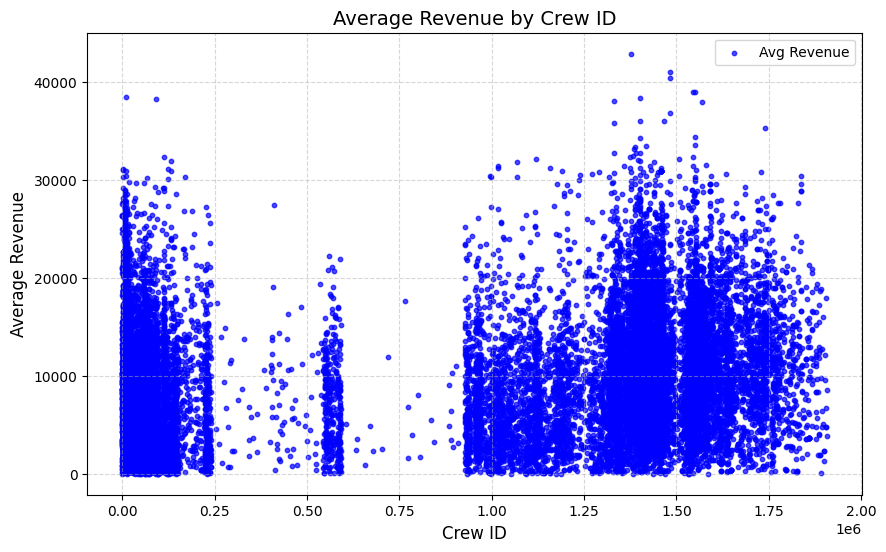

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(crew_movie_mapping.index, crew_movie_mapping['avg_rev'], alpha=0.7, s=10, c='blue', label='Avg Revenue')

plt.xlabel('Crew ID', fontsize=12)
plt.ylabel('Average Revenue', fontsize=12)
plt.title('Average Revenue by Crew ID', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()

**From the plot of Average Revenue by Crew ID, we observe several interesting patterns:**

Just like in the last figure with the cast average `revenue` distribution, this figure exhibits a layered structure, where lower average `revenue` ranges have a much higher density of crew members compared to higher ranges.<br>
This suggests that most crew members work on movies with average or below-average `revenue`, which aligns with the reality that blockbuster films are rare and involve only a subset of the crew population.<br><br>
There are also noticeable outliers, with a few crew members associated with significantly higher average `revenues`.<br> These likely represent renowned directors, producers, or other influential crew members who consistently contribute to high-revenue projects.<br><br>
To get the most out of this data, we need to process this it effectively. We will discuss this now.

**What are we going to do with this information?** <br><br> 
Instead of using raw average `revenue` values for each actor, we propose categorizing the actors into buckets. These buckets will assign actors to broader `revenue` tiers, such as "low revenue" "medium revenue" or "high revenue" based on their average movie `revenue`.

We are going to use a technique known as binning or bucketizing. This process can enhance model performance by simplifying complex relationships and reducing the impact of noise.

**Why should we do this?**
* Reduces the precision of revenue data for individual actors, making it harder for the model to overfit to specific cast members.
* Provides a more generalized and interpretable feature that still retains valuable information about the actor's contribution to revenue.
* Allows the model to focus on general trends and patterns rather than memorizing the revenue associated with specific individuals.

Let's begin applying this change.

10. We are going to first standardized the average `revenue` values in both crew_movie_mapping and cast_movie_mapping  using StandardScaler. this will transforms the data to have a mean of 0 and a standard deviation of 1, ensuring that the values are centered and scaled. This is useful for handling for the wild distribution of our data, even after the square root transformation that made the data more normal.

11. Min-Max Scaling: After standardization, the `avg_rev` values are scaled using MinMaxScaler to an int between 1 and 10.<br>
Min-Max Scaling ensures that all values fall within this range, causing the data to be in buckets.<br>
1 represents "very low revenue" and 10 represents "very high revenue".

In [35]:
scaler_standard = StandardScaler()
crew_movie_mapping['avg_rev'] = scaler_standard.fit_transform(crew_movie_mapping[['avg_rev']])
cast_movie_mapping['avg_rev'] = scaler_standard.fit_transform(cast_movie_mapping[['avg_rev']])

scaler = MinMaxScaler(feature_range=(1, 10))
crew_movie_mapping['avg_rev'] = scaler.fit_transform(crew_movie_mapping[['avg_rev']]).astype(int)
cast_movie_mapping['avg_rev'] = scaler.fit_transform(cast_movie_mapping[['avg_rev']]).astype(int)

12. Now, it's time to calculate the average revenue-bucket for each movie. This function will calculate the average bucket of a movie (by adding the buckets of all the it's actors, and calculating the mean).

In [36]:
def calculate_average_rating(movie_cast, mapping):
    member_ids = [member['id'] for member in movie_cast]  
    ratings = mapping.loc[mapping.index.isin(member_ids), 'avg_rev']
    if len(ratings) > 0:
        return ratings.mean()
    else:
        return 0 

13. Each movie will now get two new values: `avg_crew_rating` and `avg_cast_rating`.<br>
They will be the average bucket of each and every crew / cast member in the movie.

In [37]:
data_credits_filtered['avg_crew_rating'] = data_credits_filtered.apply(
    lambda row: calculate_average_rating(row['crew'], crew_movie_mapping), axis=1
)

data_credits_filtered['avg_cast_rating'] = data_credits_filtered.apply(
    lambda row: calculate_average_rating(row['cast'], cast_movie_mapping), axis=1
)

data_credits_filtered = data_credits_filtered.drop(columns=['crew', 'cast'])

Let's see the results of the change, the first plot shoes the new value each movie received. the Y-axis is the average of the buckets, and the X-axis is the movie id.

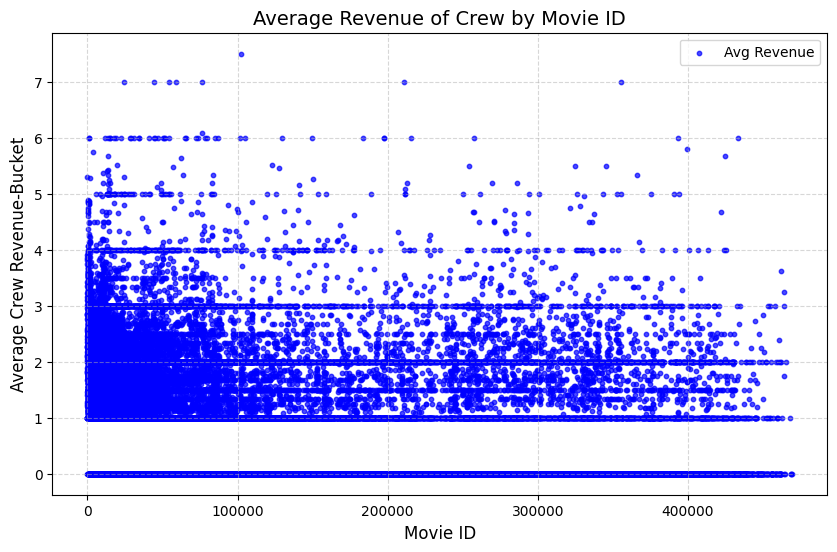

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(data_credits_filtered.index, data_credits_filtered['avg_crew_rating'], alpha=0.7, s=10, c='blue', label='Avg Revenue')

plt.xlabel('Movie ID', fontsize=12)
plt.ylabel('Average Crew Revenue-Bucket', fontsize=12)
plt.title('Average Revenue of Crew by Movie ID', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()

This plot illustrates the average of revenue-buckets of crew members associated with each movie ID. 

We see that most movies have average revenue-buckets that fall into the lower end. This aligns with the broader observation that most movies don't have A-list celebrities only in their crew.

There are some movies in with higher average revenue-buckets, indicating movies associated with higher-revenue crew members. The use of scaled revenue scores ensures that these observations are easier to interpret and model. The normalization prevents individual high-revenue movies from overly influencing the model.


Now, let's look at the cast average revenue for each movie id.

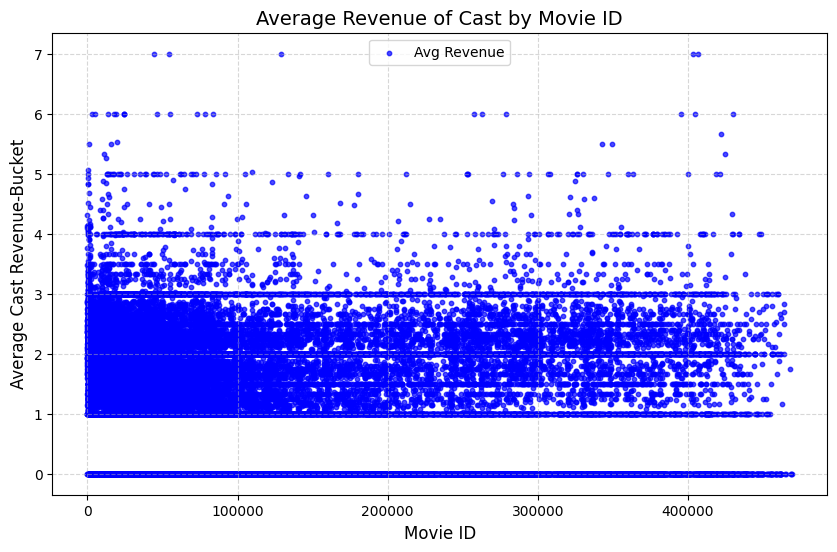

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(data_credits_filtered.index, data_credits_filtered['avg_cast_rating'], alpha=0.7, s=10, c='blue', label='Avg Revenue')

plt.xlabel('Movie ID', fontsize=12)
plt.ylabel('Average Cast Revenue-Bucket', fontsize=12)
plt.title('Average Revenue of Cast by Movie ID', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()

Like the last figure, the graph shows that most movies have average revenue-buckets of their cast members between 1 and 4, indicating that the majority of movies do not have a cast where all cast members have exceptionally high revenue.<br><br>
However, there are outliers.
This could be due to a cast with many A-list celebrities or blockbuster movie that raised all the crews average revenue-bucket.

13. Finally, we will merge between our old table and the new data we calculated.<br>
This will add the new values to each movie in our `dataset`

In [40]:
dataset = pd.merge(
    dataset,
    data_credits_filtered[['avg_crew_rating', 'avg_cast_rating']],
    left_index=True,
    right_index=True,
    how='inner'
)

Let's look at our new table after adding 2 more features (the ones we calculated above).

In [41]:
dataset.head()

,original_title,belongs_to_collection,original_language,budget,popularity,production_countries,runtime,spoken_languages,vote_average,vote_count,...,crew,cast,transformed_revenue,release_month_sin,release_month_cos,release_day_sin,release_day_cos,other,avg_crew_rating,avg_cast_rating
id,,,,,,,,,,,,,,,,,,,,,
862.0,Toy Story,1,1,30000000,21.946943,1,81.0,1,7.7,5415.0,...,106,13,19327.545964,-8.660254e-01,0.5,-0.201299,0.979530,1,4.285714,3.230769
8844.0,Jumanji,0,1,65000000,17.015539,1,104.0,2,6.9,2413.0,...,16,26,16211.022454,-2.449294e-16,1.0,0.101168,-0.994869,0,2.733333,2.625000
15602.0,Grumpier Old Men,1,1,25000000,11.712900,1,101.0,1,6.5,92.0,...,4,7,8455.767263,-2.449294e-16,1.0,-0.968077,-0.250653,0,2.000000,1.857143
31357.0,Waiting to Exhale,0,1,16000000,3.859495,1,127.0,1,6.1,34.0,...,10,10,9025.084820,-2.449294e-16,1.0,-0.968077,-0.250653,0,2.200000,2.200000
949.0,Heat,0,1,60000000,17.924927,1,170.0,2,7.7,1886.0,...,71,65,13690.756663,-2.449294e-16,1.0,0.101168,-0.994869,0,2.888889,2.528302


<font size=4px>After all those changes, we finished editing our data and we are ready to examine how those changes effected our models prediction abilities.</font>

### 4. Examining the changes
let's look at the difference in errors and residuals between the model without and with the transformation.
we'll start by creating the data for the model. we will make two copies of the `revenue` column: one with and one without the transformation.<br><br>
1. First, we will split our data to test and train. After that, we will define the pipeline from the last notebook.

In [42]:
X = dataset.drop(['transformed_revenue', 'original_title'], axis=1)
y = dataset['transformed_revenue']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

2. Now, we will define the new model pipeline with the hyperparameter chosen.

In [43]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.2,
        max_depth=7,
        random_state=42
    ))
])

3. Lastly, we are going to train our model on the train samples, and predict the results after training with the test samples.

In [44]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

Now, it's time to compare the results of our previews model with our new model:

* Below are the results of the model without transformation, meaning with the model from the last notebook. They are the same as in part 1 of the project. We will use the model we trained in the last notebook, loaded from a pickle file.

In [45]:
y_pred_load = loaded_pipeline.predict(loaded_X_test)

mae = mean_absolute_error(loaded_y_test, y_pred_load)
mse = mean_squared_error(loaded_y_test, y_pred_load)
rmse = mse ** 0.5
r2 = r2_score(loaded_y_test, y_pred_load)
residuals = loaded_y_test - y_pred_load
max_mistake = residuals.abs().max()
loaded_n = len(y_pred_load)
loaded_k = loaded_X_test.shape[1]
loeaded_r2_adjusted = 1 - ((1 - r2) * (loaded_n - 1) / (loaded_n - loaded_k - 1))
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Maximum Mistake: {max_mistake:.2f}")
print(f"Number of Explanatory Vriable: {loaded_k}")
print(f"Adjusted R-squared (R2): {loeaded_r2_adjusted:.2f}")


Mean Absolute Error (MAE): 38273447.15
Mean Squared Error (MSE): 5406834868055707.00
Root Mean Squared Error (RMSE): 73531182.96
R-squared (R2): 0.82
Maximum Mistake: 816002192.00
Number of Explanatory Vriable: 32
Adjusted R-squared (R2): 0.82


* Now, let's look at our new model's results, with the model after transformation. Notice after predicting, we transformed the data to match with the real revenue.<br>
Because the transformation we did was square root, now we use power of 2 to return the predictions and the test `revenue` values to their original predicted values.

In [46]:
y_test =  y_test ** n
y_pred = y_pred ** n
mae_transformed = mean_absolute_error(y_test, y_pred)
mse_transformed = mean_squared_error(y_test, y_pred)
rmse_transformed = mse_transformed ** 0.5
r2_transformed = r2_score(y_test, y_pred)
residuals_transformed = y_test - y_pred
max_mistake_transformed = residuals_transformed.abs().max()
new_n = len(y_pred)
new_k = X_test.shape[1]
new_r2_adjusted = 1 - ((1 - r2_transformed) * (new_n - 1) / (new_n - new_k - 1))
print(f"Mean Absolute Error (MAE): {mae_transformed:.2f}")
print(f"Mean Squared Error (MSE): {mse_transformed:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_transformed:.2f}")
print(f"R-squared (R2): {r2_transformed:.2f}")
print(f"Maximum Mistake: {max_mistake_transformed:.2f}")
print(f"Number of Explanatory Vriable: {new_k}")
print(f"Adjusted R-squared (R2): {new_r2_adjusted:.2f}")

Mean Absolute Error (MAE): 23381111.64
Mean Squared Error (MSE): 3630584428785551.50
Root Mean Squared Error (RMSE): 60254331.20
R-squared (R2): 0.83
Maximum Mistake: 1372738847.00
Number of Explanatory Vriable: 32
Adjusted R-squared (R2): 0.83


<font size=4px>**Let's compare the results of the model:**</font><br>

| Metric                      | Last Model             | New Model                | Percentage Decrease |
|-----------------------------|------------------------|--------------------------|---------------------|
| Mean Absolute Error (MAE)   | 38,273,447.15          | 23,381,111.64            | 38.9104%            |
| Mean Squared Error (MSE)    | 5,406,834,868,055,707.00 | 3,630,584,428,785,551.50 | 32.8519%          |
| Root Mean Squared Error     | 73,531,182.96          | 60,254,331.20            | 18.0561%            |
| R-squared (R2)              | 0.82                   | 0.83                     | 1.21951% (inc)      |
| Maximum Mistake             | 816,002,192.00         | 1,372,738,847.00         | 68.2273%   (inc)    |
| Number of Variables         | 32                     | 32                       | 0                   |
| Adjusted R-squared (R2)     | 0.82                   | 0.83                     | 1.21951%  (inc)     |


* **Improvement in MAE, MSE, and RMSE:**
The new model shows a significant reduction in the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). These metrics indicate that the predictions of the new model are closer to the actual `revenue` values compared to the previous model. The lower error rates suggest that the new model is making more accurate predictions overall.

    Those changes come from a smart feature engineering that allowed the model to learn the different attributes better. We will later see how the features we added (and dropped) helped the model predict more accurate results.

* **Increase in R-squared (R²):**
The R² value of the new model has increased, which means that it better explains the variance in `revenue`. A higher R² indicates that the new model is capturing more meaningful relationships between the explanatory variables and the `revenue`.

* **Adjusted R-squared (R²):**
The adjusted R² value has also increased, which is an important indicator of model improvement. Adjusted R² accounts for the number of features (explanatory variables) used in the model and penalizes the addition of irrelevant features.
In this case, we made significant changes to the feature set. While the number of explanatory variables remained the same, we removed some less meaningful features (some genres) and added new, more informative features. Additionally, we incorporated previously missing data from a new table, which increased the number of observations in the dataset. This proves that the adjusted R² increase is due to actual model improvements rather than the mere addition of features.

* **Increase in Maximum Mistake:**
Despite the overall improvement in the model, the maximum error has increased significantly. This can be explained by the inclusion of the movie "Avatar" in the test set of the new model. "Avatar" is one of the highest-grossing movies of all time, with `revenue` around $2.7 billion, which creates an outlier in the predictions. The previous model's test set did not include "Avatar," so the maximum error was lower.

**Now, we want to compare the predicted vs the actual `revenue` from the last model with our new model.**

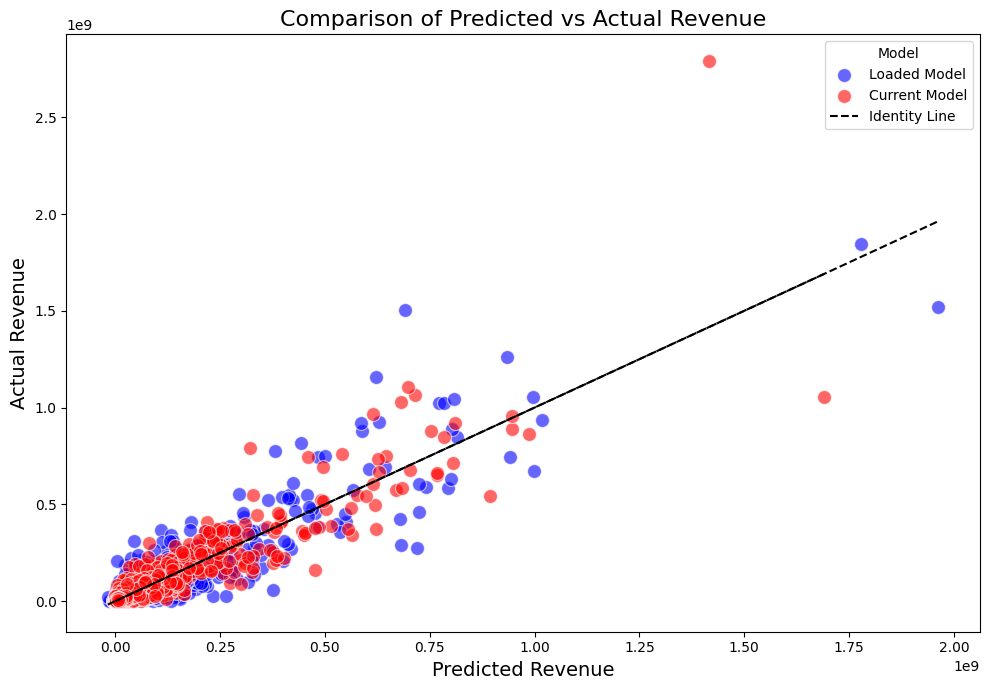

In [47]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(x=y_pred_load, y=loaded_y_test, ax=ax, color='blue', label='Loaded Model', alpha=0.6, s=100)

sns.scatterplot(x=y_pred, y=y_test, ax=ax, color='red', label='Current Model', alpha=0.6, s=100)

sns.lineplot(x=y_pred_load, y=y_pred_load, ax=ax, color='black', linestyle='--', label='Identity Line')
sns.lineplot(x=y_pred, y=y_pred, ax=ax, color='black', linestyle='--')

ax.set_title('Comparison of Predicted vs Actual Revenue', fontsize=16)
ax.set_xlabel('Predicted Revenue', fontsize=14)
ax.set_ylabel('Actual Revenue', fontsize=14)
ax.legend(title='Model')

plt.tight_layout()
plt.show()

**Comparing Loaded Model vs. Current Model**

* **Loaded Model (Blue Dots):** The blue dots represent the loaded model's predictions. The loaded model shows a clustering of predictions around the lower end of the `revenue` scale, with a spread that stays relatively close to the identity line, indicating a moderate level of accuracy across its predictions.

* **Current Model (Red Dots):** The red dots represent the current model's predictions. It appears that the current model's predictions are slightly closer to the identity line compared to the loaded model, especially in the mid `revenue` range, which suggests an improvement in accuracy.

**Comparative Insights:**

* **Distribution of Errors:** While both models exhibit some errors, the distribution and density of the red dots suggest that the current model has fewer extreme outliers in terms of prediction errors, thereby offering a more reliable model for practical use. It is worth to note the the new model has a larger dataset which means more data in the test set. This means even with more data the newer models predicts closer to the identity line in most of the range of `revenue` values.

Overall, the comparison clearly shows that our current model, which included feature adjustments and optimization, was able to achieve better prediction accuracy. This visual analysis not only confirms the statistical improvements seen in the reduced mean absolute error and mean squared error but also highlights the practical improvements in model performance on the task of predicting movie revenues.

**Now, let's look at the residuals diffrence from our old model and our new model. We will begin with our old model.**

Text(0, 0.5, 'Residuals as % of True Values')

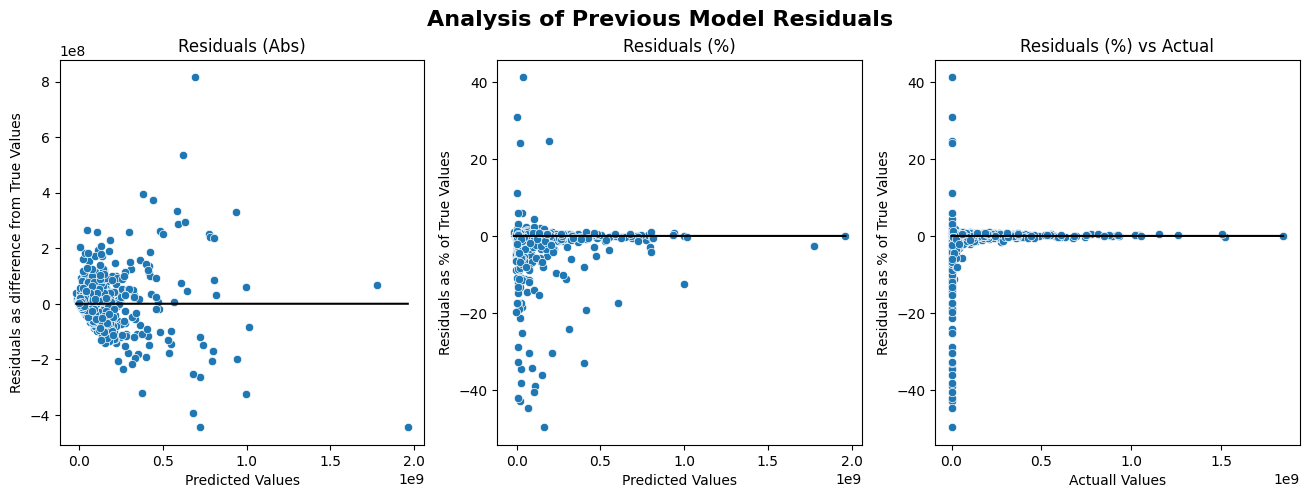

In [48]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
fig.suptitle('Analysis of Previous Model Residuals', fontsize=16, fontweight='bold')

sns.scatterplot(x= y_pred_load,y = residuals,ax=ax[0])
sns.lineplot(x= y_pred_load, y = 0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].set_xlabel("Predicted Values")  
ax[0].set_ylabel("Residuals as difference from True Values") 
filtered_residuals = residuals[(residuals / loaded_y_test).abs() < 50]
sns.scatterplot(x=y_pred_load, y=filtered_residuals / loaded_y_test, ax=ax[1])
sns.lineplot(x=y_pred_load, y=0, ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].set_xlabel("Predicted Values")  
ax[1].set_ylabel("Residuals as % of True Values")  
sns.scatterplot(x=loaded_y_test, y=filtered_residuals / loaded_y_test, ax=ax[2])
sns.lineplot(x=loaded_y_test, y=0, ax=ax[2], color='black')
ax[2].set_title("Residuals (%) vs Actual")
ax[2].set_xlabel("Actuall Values")  
ax[2].set_ylabel("Residuals as % of True Values")

Now, let's look at the results from our new model, and compare the results.

Text(0, 0.5, 'Residuals as % of True Values')

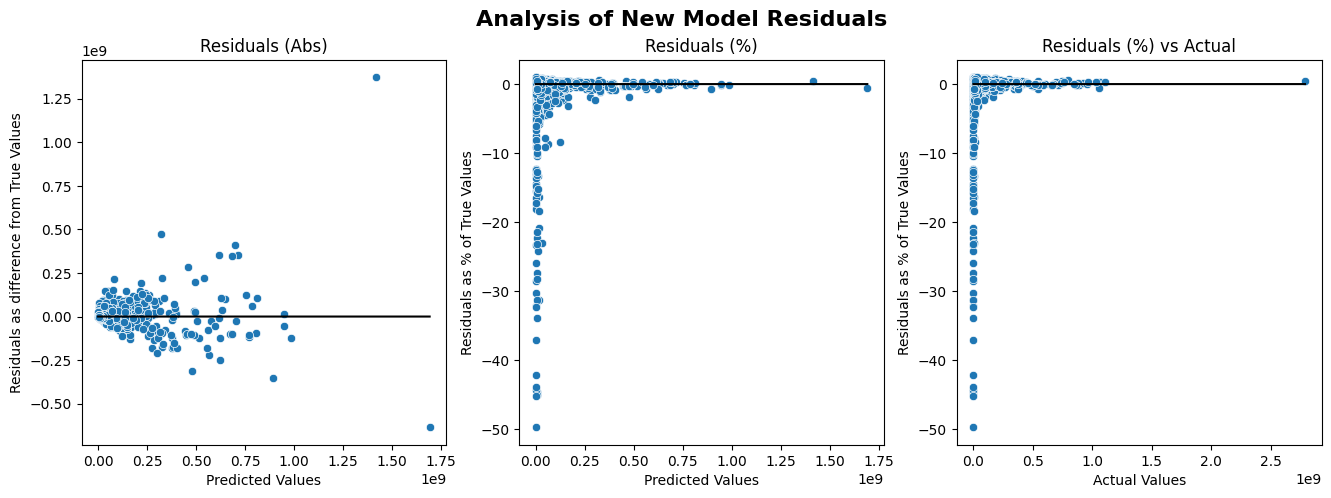

In [49]:
mask = (residuals_transformed / y_test).abs() < 50

filtered_residuals = residuals_transformed[mask]
filtered_y_pred = y_pred[mask]
filtered_y_test = y_test[mask]

fig, ax = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Analysis of New Model Residuals', fontsize=16, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_transformed, ax=ax[0])
sns.lineplot(x=y_pred, y=0, ax=ax[0], color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].set_xlabel("Predicted Values")  
ax[0].set_ylabel("Residuals as difference from True Values") 

sns.scatterplot(x=filtered_y_pred, y=filtered_residuals / filtered_y_test, ax=ax[1])
sns.lineplot(x=filtered_y_pred, y=0, ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].set_xlabel("Predicted Values")  
ax[1].set_ylabel("Residuals as % of True Values")  

sns.scatterplot(x=filtered_y_test, y=filtered_residuals / filtered_y_test, ax=ax[2])
sns.lineplot(x=filtered_y_test, y=0, ax=ax[2], color='black')
ax[2].set_title("Residuals (%) vs Actual")
ax[2].set_xlabel("Actual Values")
ax[2].set_ylabel("Residuals as % of True Values")

**Comparative Analysis of Model Residuals**

We conducted a comparative analysis of residuals between our previous and new models to understand the improvements in model performance, particularly in how they predict movie revenues. Here are our observations:

**1. Absolute Residuals:**
- **Previous Model**: The residuals displayed significant variance, with large errors particularly at higher predicted values, indicating inconsistency.
- **New Model**: Shows tighter clustering of residuals around the zero line, suggesting that the predictions are generally closer to actual values across all revenue ranges.

**2. Residuals as a Percentage of Predicted Values:**
- **Previous Model**: Residuals were dispersed around zero but showed variability as predicted values increased, reflecting proportional inaccuracies in predictions.
- **New Model**: Residuals are more uniformly close to zero across all predicted values, highlighting a consistent improvement in the model’s accuracy in percentage terms.

**3. Residuals as a Percentage of Actual Values:**
- **Previous Model**: The residuals near zero for lower actual values were tightly grouped but spread significantly for higher values, indicating a struggle to accurately predict higher revenue movies.
- **New Model**: There is a notable improvement with residuals tightly bunched near zero for higher actual values as well, which points to an enhanced capability of the model to predict accurately across higher revenue scales.

These improvements are due to the optimized feature engineering in the new model, where less informative variables were removed, and more predictive indicators were introduced. Additionally, the incorporation of more comprehensive training data has likely helped the model’s generalization capabilities, leading to increased accuracy and reliability in predictions.

**Let's look at a new metric called pearson correlation**<br><br>
Pearson Correlation Coefficient is as metric that measures the linear correlation between the predicted values and the actual values of the target variable, in this case, `revenue`. A Pearson correlation coefficient of 1 implies a perfect positive linear relationship, -1 implies a perfect negative linear relationship, and 0 implies no linear relationship.

Let's calculate the pearson correlation of our old model and new model.

In [50]:
pearson_corr_loaded, _ = pearsonr(loaded_y_test, y_pred_load)
print(f"Pearson Correlation Coefficient, Old Model: {pearson_corr_loaded:.2f}")

pearson_corr_transformed, _ = pearsonr(y_test, y_pred)
print(f"Pearson Correlation Coefficient, New Model: {pearson_corr_transformed:.2f}")

Pearson Correlation Coefficient, Old Model: 0.91
Pearson Correlation Coefficient, New Model: 0.91


The Pearson Correlation Coefficients for both models are identical at **0.91**, indicating that both models have a strong and equal linear relationship with the actual revenue values.

Despite this similarity, the most significant improvements in the new model are observed in the **RMSE** (Root Mean Squared Error) and **MAE** (Mean Absolute Error). These improvements suggest that the new model has enhanced accuracy in predicting the revenue values, reducing the average errors in predictions, which directly contributes to more reliable and precise forecasting.

This enhancement is crucial for decision-making processes that rely on the accuracy of predicted revenues.

**Now, we would like to examine feature importance and see how the new features we added helped the model's predictions.**

To begin with, we will examine the new SHAP plot of our model.

PermutationExplainer explainer: 501it [00:48,  8.27it/s]                         


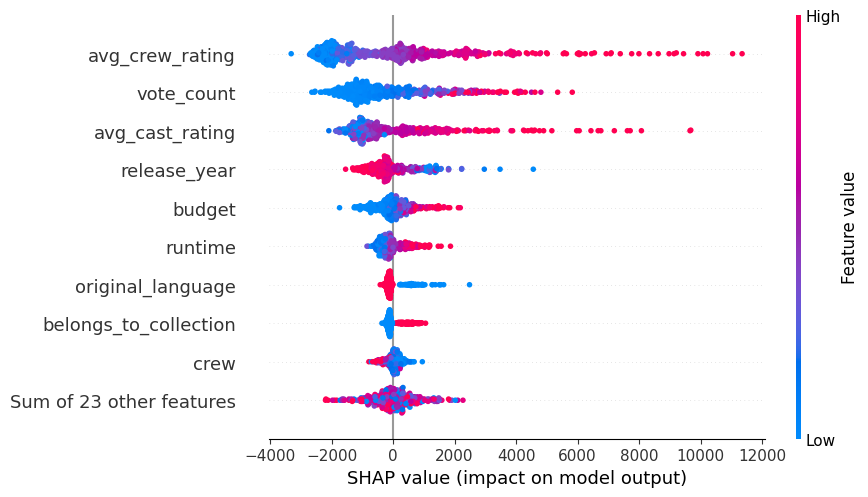

In [51]:
shap_sample = X_train.sample(500)
explainer = shap.Explainer(pipeline.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

**What Can We Understand From The SHAP Plot?**

The introduction of new features in our model has significantly highlighted the importance of both the cast and crew in determining a film's revenue. This analysis reveals that the use of the crew and cast influenced movie revenues and had a great impact on predicting the `revenue`.

* **Average Cast Rating:**
The influence of the `average cast rating` on the revenue predictions is interesting. While higher ratings of cast members contribute positively towards higher revenue predictions, the spread of SHAP values across both high and low feature values suggests variability in how much star power alone can predict a film's financial success.<br><br>
This spread indicates that while a highly rated cast can be a strong driver of revenue, its effect is not uniformly predictive across all movies, potentially due to varying genres, movie types, or audience preferences that may value narrative or directorial prowess over star cast.

* **Average Crew Rating:**
The `average crew rating` shows a consistently higher impact on the revenue predictions compared to the cast. This effect is positive, indicating that movies with highly rated crews are generally expected to perform better financially.<br><br>
The dominance of crew ratings in influencing revenue underscores the critical role of behind-the-scenes talent such as directors, producers, and technical teams. Their expertise appears to be a more reliable predictor of a movie's success, likely reflecting the importance of production quality, direction, and execution over star power alone.

The `vote count` emerged as a particularly strong predictor, suggesting that broader audience engagement and buzz around a film are substantial drivers of box office success. This indicates that widespread popularity and audience reception, reflected through active engagement metrics like `vote count`, can have a more pronounced impact on `revenue` than the specific actors involved.

Moreover, the differential impact of cast versus crew might also hint at the relative experience levels within the film industry. Newer actors, who might initially feature predominantly in lower-budget indie films, could exhibit lower average `revenue` metrics compared to more established actors. However, a skilled and experienced crew can enhance a film's production quality significantly, thereby influencing its commercial success more decisively.

These insights not only confirm the importance of a skilled crew but also highlight the complex dynamics between cast reputation, crew expertise, and audience perception in determining a movie's financial outcome.

**Now, let's look at the SHAP values of the new features we added (the ones that were not seen in the plot above). Let's first look at the features related to the date.**

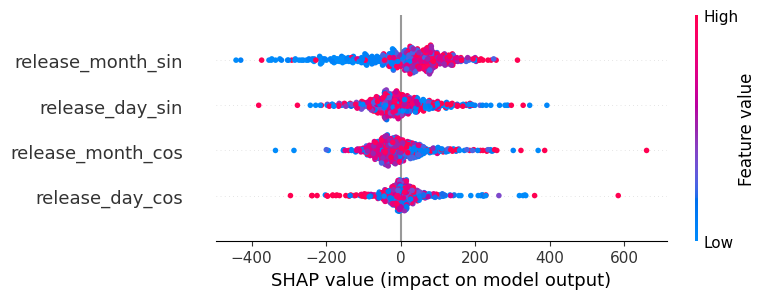

In [52]:
important_features = ['release_month_sin', 'release_month_cos', 'release_day_sin', 'release_day_cos']

features_indices = [shap_sample.columns.get_loc(col) for col in important_features if col in shap_sample.columns]

features_shap_values = shap_values[:, features_indices]

shap.summary_plot(features_shap_values, shap_sample[important_features], feature_names=important_features)

This SHAP plot for the date-related features (release month and day using sine and cosine transformations) reveals some interesting insights about how these features influence the model's predictions:

* **Release Month Sine and Cosine:** These features model the cyclical nature of `release months`. The plot indicates that the time of year when a movie is released has a measurable impact on its `revenue`. The spread of SHAP values across the zero line (especially for the sine transformation) suggests that certain months may be more favorable for movie releases, potentially aligning with seasonal audience availability and major holiday periods which are likely to boost `revenue`.

* **Release Day Sine and Cosine:** Similarly, these features capture the cyclical pattern of days within a month. The relatively tighter clustering of the SHAP values around the zero line compared to the month suggests that the specific day of release within a month has a less pronounced but still noticeable effect on movie revenues. This might reflect weekly patterns such as higher `revenue` on weekends or specific release strategies targeting optimal days within a month for movie premieres.

To conclude, the overall distribution of SHAP values for these date-related features suggests that while the timing of a movie release does not have the most dominant influence on `revenue`, it plays a significant role that the model has learned to capture. This can be crucial for distributors and producers when planning release dates to maximize box office returns.

**Now, let's observe how the genre features impact the models prediction. Remember that we dropped some of the genres, and added the `other` column.**

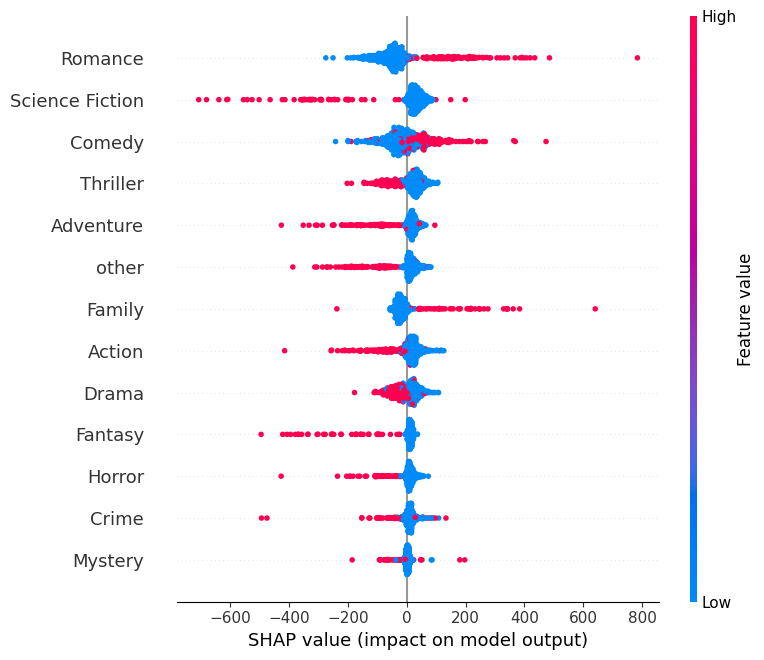

In [53]:
genre_columns = [
     'Science Fiction', 'Romance', 'Action', 'Crime', 'Thriller', 'Family', 'Fantasy', 'Horror', 
    'Comedy', 'Adventure', 'Mystery', 'Drama', 'other'
]

genre_indices = [shap_sample.columns.get_loc(col) for col in genre_columns if col in shap_sample.columns]

genre_shap_values = shap_values[:, genre_indices]

shap.summary_plot(genre_shap_values.values, shap_sample[genre_columns], feature_names=genre_columns)


**What Can We Observe From The New SHAP Plotting?**

First, we see a significant improvement in the feature representation. In the old model, genres like Science Fiction, Comedy, and Romance showed great impacts, but there was a spread across many genre types. In the updated model, we grouped less significant genres into the 'other' category, simplifying how genres affect the model's predictions.

The 'other' feature in the new model aggregates the impact of less frequent genres, reducing noise and enhancing the model's predictions. This removal helps **focus on more dominant genres** that have clearer effects on revenue, such as Family and Science Fiction, which continue to show strong positive impacts.

Additionally, the new model reveals a more balanced influence across the remaining genres, indicating a deeper understanding of how different genres contribute to movie revenue. By refining genre features, we've potentially increased the model's ability to capture relevant variability in the data without being overwhelmed by less informative features.

This strategic feature engineering step not only cleans up the data input but also potentially improves the model’s performance by focusing on more impactful variables. It is a clear demonstration of how thoughtful data preprocessing and feature selection can lead to more efficient and interpretable models.

### 5. Conclusions About the Data & Creative Applications

<font size='4px'>*Feature Correlation*</font>

In our analysis, we aim to explore the correlations between various features and their impact on the movie's revenue. Understanding these relationships will help us identify which factors are most influential and may expose potential biases in our dataset. By examining the correlation matrix, we can discern how closely related different variables are to each other and to the outcome variable, revenue.

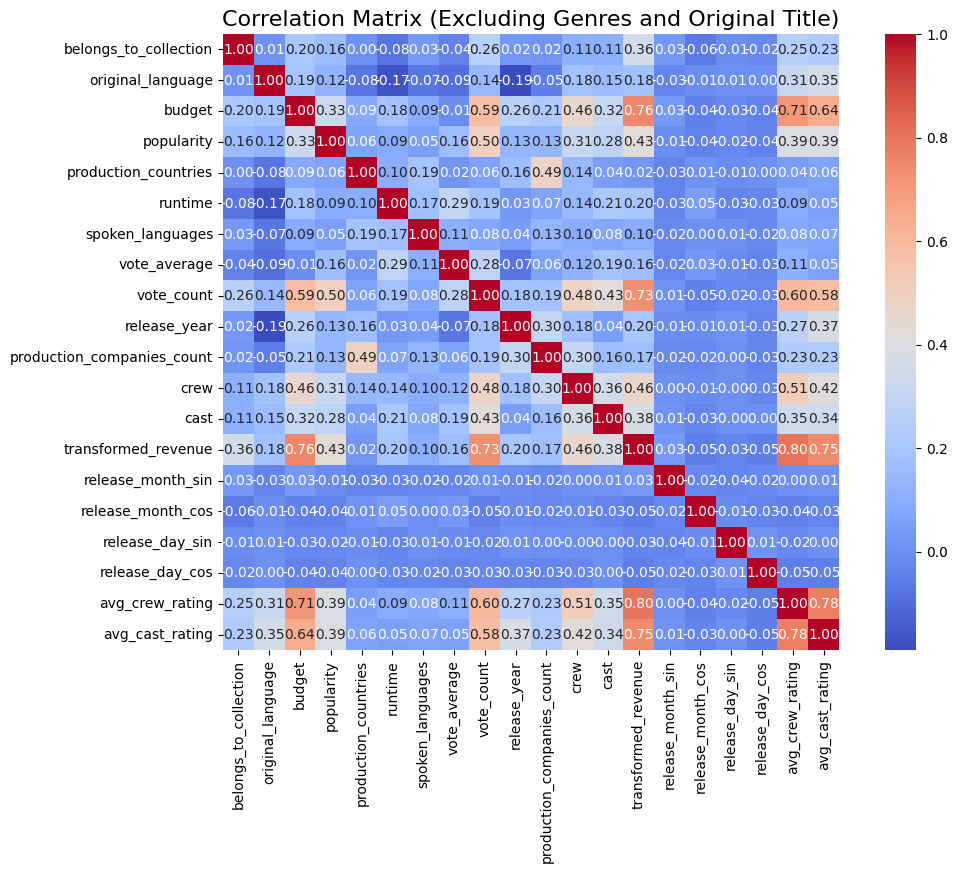

In [54]:
columns_to_drop = genre_columns + ['original_title']
data_without_genres_and_title = dataset.drop(columns=columns_to_drop, axis=1)

correlation_matrix = data_without_genres_and_title.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix (Excluding Genres and Original Title)", fontsize=16)
plt.show()


**Findings from the Correlation Matrix:**

The heatmap above provides a detailed look at the correlations between different features in our dataset. Let's analyze some results:

* **High Correlation with Revenue:** The features `avrage cast / crew rating`, `budget`, and `vote_count` show a strong positive correlation with revenue, indicating their significant impact on a movie's financial success. This suggests that movies that have expirianced people, movies that have higher `budgets`, and receive more `votes` tend to generate higher `revenue`.

* **Influence of Crew and Cast Ratings:** Both `avg_crew_rating` and `avg_cast_rating` show a very high positive correlation with `revenue`, underscoring the importance of the quality and popularity of the cast and crew in driving box office earnings. This shows the importance of adding those features, because they have strong correlation with the target value, that helped our model learn. 

* **Medium Influence of Popularity and Runtime:** `Popularity` and `original_language` also correlate positively with `revenue`, though their value is smaller. This indicates that more `popular` movies and those that are in English are likely to achieve higher earnings, possibly due to more extensive engagement with audiences or higher production values. Movies that are in english can be understood without the need for translation in most of the world, and are more likely to be from a large production company. 

* **Low Impact of Release Timing:** The release timing features (`release_month_sin`, `release_month_cos`, `release_day_sin`, `release_day_cos`) show very low correlation with `revenue`. This suggests that the specific timing of a movie's release has minimal direct impact on its `revenue` potential.

Lastly, it is important to observe the possible multicollinearity Concerns: The correlations between some independent variables, such as 'vote_count' and 'popularity', are also relatively high, which could lead to multicollinearity issues. This overlap might affect the stability and interpretability of our model, necessitating further analysis or potential feature engineering to address these issues.

*** We will now check for multicollinearity using VIT (variance inflation factor) ***

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("\nVariance Inflation Factor (VIF):\n", vif_data)



Variance Inflation Factor (VIF):
                        feature         VIF
0        belongs_to_collection    1.564594
1            original_language    9.216461
2                       budget    4.048556
3                   popularity    2.110760
4         production_countries    4.801086
5                      runtime   39.356349
6             spoken_languages    3.999805
7                 vote_average   51.240818
8                   vote_count    3.052570
9              Science Fiction    1.321623
10                     Romance    1.458492
11                      Action    1.900098
12                       Crime    1.458654
13                    Thriller    2.051192
14                      Family    1.551660
15                     Fantasy    1.290898
16                      Horror    1.540847
17                      Comedy    2.328580
18                   Adventure    1.655677
19                     Mystery    1.232396
20                       Drama    3.016062
21                r

Looking at the VIF values, we see most are not high at all. This may mean there is not much multicollinearity. <br>

Some features do have quite high VIF values, and one surprising feature is `release_year` with a VIF value of 100 (!). This is surprising because this feature is of a year and doesn't share any similarities with the other features.<br>
If other features (e.g., `budget`, `vote_avrage`, `popularity`) exhibit temporal trends, the model may be picking up hidden dependencies related to industry changes over time.

Other features with high VIF values are expected after examining the correlation matrix.
`avg_cast_rating`, `avg_crew_rating`, `vote_average` have high correlation with one another.

Another surprising result is the relatively low VIF value in `budget`. This is surprising because the correlation matrix show high correlation between it and other features.

<font size='4px'>*Surprising Findings*</font>

<font size='4px'>*Creative Applications*</font><br>

There are many real-world applications for a model like this one. 
A movie production studio may want to use a similar model for finding the best variables for a specific movie in mind.<br>
For example, a studio TA wants to make a fantasy film in english, the can find the best length for the movie, and which combination of actors work best given their budget, and more. 

### Inspiration:

1. After noticing the extreme skewnes of the `revenue`, we looked into reasong to transform the data to be more normal.<br>
We found a few articles that explain what transformations work well and how to interpretete them.<br>
We chose to perform a square root transformation on the `revenue` value.<br>
[Data transformation: a focus on the interpretation](https://pmc.ncbi.nlm.nih.gov/articles/PMC7714623/)<br>